In [ ]:
!pip install deepxde

In [1]:
import os
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'deepxde'

In [ ]:
os.makedirs("training_outputs", exist_ok=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.432938 s

'compile' took 4.466623 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [6.40e+05]    [6.40e+05]    [3.86e-01]    
1000      [5.62e+05]    [5.71e+05]    [3.13e-01]    
2000      [5.62e+05]    [5.71e+05]    [3.07e-01]    
3000      [5.62e+05]    [5.71e+05]    [3.07e-01]    
4000      [5.62e+05]    [5.71e+05]    [3.07e-01]    
5000      [4.29e+05]    [4.65e+05]    [3.18e-01]    
6000      [2.43e+05]    [5.47e+05]    [2.50e-01]    
7000      [1.53e+05]    [8.02e+05]    [2.00e-01]    
8000      [9.68e+04]    [9.85e+05]    [1.62e-01]    
9000      [8.68e+05]    [8.54e+05]    [2.49e-01]    
10000     [4.70e+05]    [4.83e+05]    [3.09e-01]    
11000     [4.30e+05]    [4.45e+05]    [3.07e-01]    
12000     [3.89e+05]    [4.07e+05]    [2.87e-01]    
13000     [3.39e+05]    [3.64e+05]    [2.69e-01]    
14000     [3.04e+05]    [3.37e+05]    [2.48e-01]    
15000     [2.74e+05]  

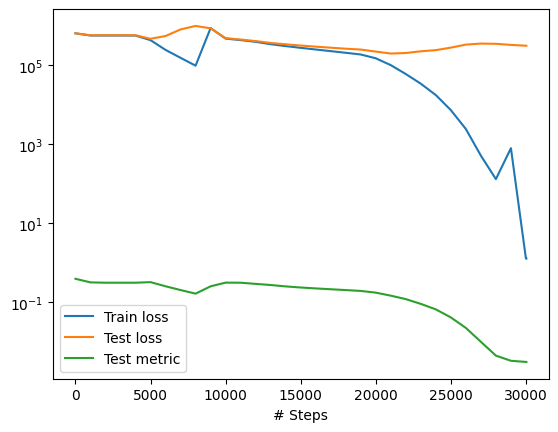

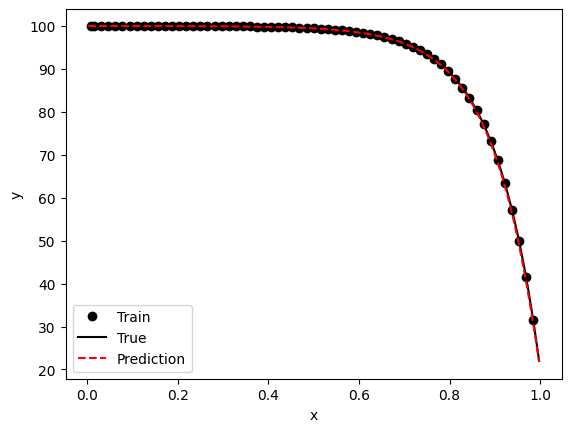

<ipython-input-33-6d16c62e3f56>:96: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


In [ ]:
length = 1
T_hot = 100
T_cold = 20
diff_coeff = 1
density = 1
u = 10

geom = dde.geometry.Interval(0,length)

def pde(x,y):
  dy_dx = dde.grad.jacobian(y,x)
  d2y_dx2 = dde.grad.hessian(y,x)

  return density * u * dy_dx - diff_coeff * d2y_dx2


def func(x):
  return T_hot + (np.exp(density * u * x / diff_coeff)-1) / (np.exp(density * u * length / diff_coeff)-1) * (T_cold - T_hot)

def boundary_left(x,_):
  return dde.utils.isclose(x[0],0)
def boundary_right(x,_):
  return dde.utils.isclose(x[0],1)
bc_left = dde.icbc.DirichletBC(geom, lambda x: T_hot, boundary_left)
bc_right = dde.icbc.DirichletBC(geom, lambda x: T_cold, boundary_right)
# data = dde.data.PDE(geom,pde,[bc_left,bc_right],num_domain=64, solution=func,num_test=400)
data = dde.data.PDE(geom,pde,[],num_domain=64, solution=func,num_test=400)

layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation,initializer)

def output_transform(x, y):
    return T_hot + (T_cold - T_hot) * x / length + x * (x - length) * y

net.apply_output_transform(output_transform)

def plot_and_save(step, model):
    # Predict the solution
    y_pred = model.predict(x)
    y_true = func(x)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, y_pred, label='Predicted')
    plt.plot(x, y_true,'ko', label='True')
    plt.title(f'Solution at step {step}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

    # Save the plot
    plt.savefig(f"training_outputs/step_{step:06d}.png")
    plt.close()

# Generate points for prediction
x = np.linspace(0, length, 50)[:, None]

class PlotCallback(dde.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.step = 0

    def on_epoch_end(self):
        if self.step == 0:
          plot_and_save(self.step, self.model)
        self.step += 1
        if self.step % 50 == 0:  # Save plot every 50 steps
            plot_and_save(self.step, self.model)

# Create the callback
plot_callback = PlotCallback()

model = dde.Model(data,net)
model.compile("adam", lr=0.001,metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=30000,callbacks=[plot_callback])
# Configure L-BFGS
dde.optimizers.config.set_LBFGS_options(
    maxcor=5000,
    ftol=1e-8,
    gtol=1e-8,
    maxiter=5000,
    maxfun=None,
    maxls=5000
)
model.compile("L-BFGS",metrics=["l2 relative error"])
losshistory, train_state = model.train(callbacks=[plot_callback])
dde.saveplot(losshistory,train_state,issave=False,isplot=True)

def create_gif(image_folder, gif_name):
    images = []
    for file_name in sorted(os.listdir(image_folder)):
        if file_name.endswith('.png'):
            file_path = os.path.join(image_folder, file_name)
            images.append(imageio.imread(file_path))
    imageio.mimsave(gif_name, images, fps=20)

# Create the animation
create_gif('training_outputs', 'training_animation.gif')

Compiling model...
'compile' took 1.423649 s

Training model...

30000     [1.81e+05]    [3.65e+05]    [2.01e-01]    
30033     [1.81e+05]    [3.65e+05]    [2.01e-01]    

Best model at step 28000:
  train loss: 1.65e+05
  test loss: 1.03e+06
  test metric: [1.90e-01]

'train' took 6.282951 s



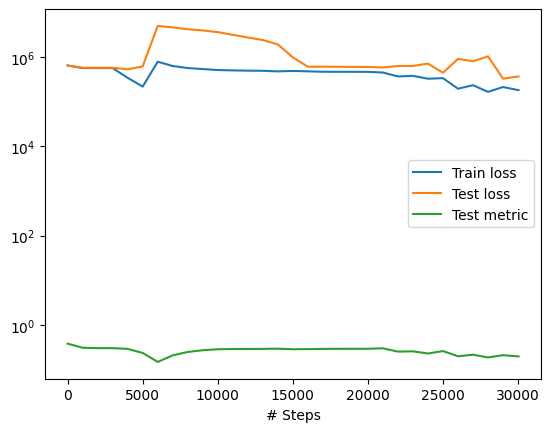

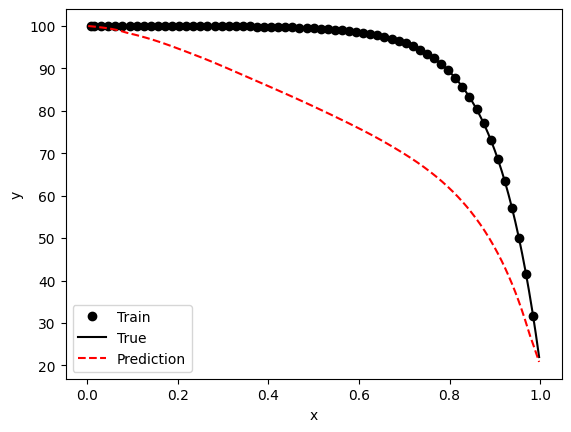

In [ ]:
model.compile("L-BFGS",metrics=["l2 relative error"])
losshistory, train_state = model.train(callbacks=[plot_callback])
dde.saveplot(losshistory,train_state,issave=False,isplot=True)

In [ ]:
!pip install imageio

In [ ]:
import imageio
import os

def create_gif(image_folder, gif_name):
    images = []
    for file_name in sorted(os.listdir(image_folder)):
        if file_name.endswith('.png'):
            file_path = os.path.join(image_folder, file_name)
            images.append(imageio.imread(file_path))
    imageio.mimsave(gif_name, images, fps=20)

# Create the animation
create_gif('training_outputs', 'training_animation.gif')

<ipython-input-36-26c57e70ac3f>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))
